In [1]:
# based on https://wroscoe.github.io/keras-lane-following-autopilot.html

import os
import urllib.request
import pickle
import numpy as np
import cv2
from tools import import_data, shuffle_data, split_data

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow, imread

# Get Data

X shape:  (2336, 128, 160, 3)
y shape:  (2336,)
X shape:  (2336, 93, 160, 3)


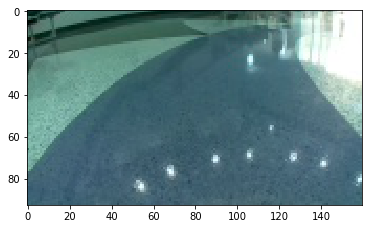

In [2]:
raw_X, raw_y = import_data('../inloop')
print('X shape: ', raw_X.shape)
print('y shape: ', raw_y.shape)

# crop out the horizon
raw_X = raw_X[:,35:,:,:]
print('X shape: ', raw_X.shape)
imshow(raw_X[0])

In [3]:
shuffled_X, shuffled_y = shuffle_data(raw_X, raw_y)

In [4]:
train_X, train_y, val_X, val_y, test_X, test_y = split_data(shuffled_X, shuffled_y, 0.8, 0.1)

print('Train: ', len(train_X))
print('Validation: ', len(val_X))
print('Test: ', len(test_X))
print('Total: ', len(train_X) + len(val_X) + len(test_X))

Train:  1868
Validation:  233
Test:  235
Total:  2336


In [5]:
# flip images to remove steering bias
X_flipped = np.array([np.fliplr(i) for i in train_X])
y_flipped = np.array([-i for i in train_y])
train_X = np.concatenate([train_X, X_flipped])
train_y = np.concatenate([train_y, y_flipped])
len(train_X)

3736

In [10]:
from keras.models import Sequential
from keras.layers import *

# Udacity SDC Model

In [11]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(93, 160, 3)))
model.add(Convolution2D(24, (5,5), strides=(2,2), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(36, (5,5), strides=(2,2), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(48, (5,5), strides=(2,2), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), strides=(1,1), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), strides=(1,1), padding='valid', kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1164, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(Dense(100, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(Dense(50, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(Dense(10, kernel_initializer='he_normal'))
model.add(Activation('elu'))
#model.add(Dropout(0.2))

model.add(Dense(1, kernel_initializer='he_normal'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 93, 160, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 78, 24)        1824      
_________________________________________________________________
activation_10 (Activation)   (None, 45, 78, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 37, 36)        21636     
_________________________________________________________________
activation_11 (Activation)   (None, 21, 37, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 17, 48)         43248     
_________________________________________________________________
activation_12 (Activation)   (None, 9, 17, 48)         0         
__________

# Train

In [12]:
from keras import callbacks
model_path = os.getcwd() + '/models/udacity_model.hdf5'
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [13]:
model.fit(train_X, train_y, batch_size=32, epochs=10, validation_data=(val_X, val_y), callbacks=callbacks_list)

Train on 3736 samples, validate on 233 samples
Epoch 1/10
3736/3736 [==============================] - 47s - loss: 9191.3732 - val_loss: 4102.2162
Epoch 2/10
3736/3736 [==============================] - 46s - loss: 2908.6829 - val_loss: 2936.7189
Epoch 3/10
3736/3736 [==============================] - 46s - loss: 2349.6740 - val_loss: 2594.6008
Epoch 4/10
3736/3736 [==============================] - 46s - loss: 2197.1027 - val_loss: 2446.3598
Epoch 5/10
3736/3736 [==============================] - 46s - loss: 2248.5461 - val_loss: 2658.5722
Epoch 6/10
3736/3736 [==============================] - 48s - loss: 1940.9049 - val_loss: 2491.1690
Epoch 7/10
3736/3736 [==============================] - 52s - loss: 1833.5855 - val_loss: 2366.7938
Epoch 8/10
3736/3736 [==============================] - 48s - loss: 1708.4063 - val_loss: 2009.4631
Epoch 9/10
3736/3736 [==============================] - 48s - loss: 1591.0003 - val_loss: 1862.4927
Epoch 10/10
3736/3736 [==============================

# Evaluate

In [14]:
import pandas as pd
from keras.models import load_model
model = load_model(model_path)

# Test Data

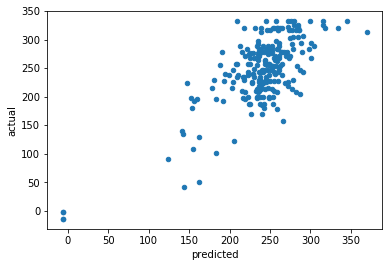

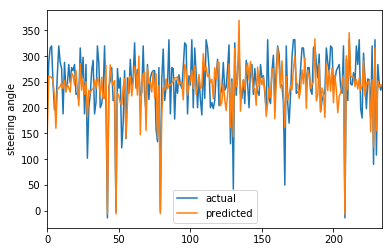

In [15]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape((pred_y.shape[0],))
df = pd.DataFrame({'predicted':pred_y, 'actual':test_y})
ax = df.plot.scatter('predicted', 'actual')
ax2 = pd.DataFrame({'predicted':pred_y, 'actual':test_y}).plot()
ax2.set_ylabel('steering angle')

# Training Data

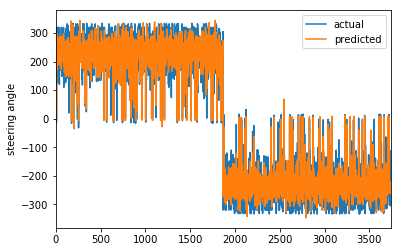

In [16]:
pred_y_2 = model.predict(train_X)
pred_y_2 = pred_y_2.reshape((pred_y_2.shape[0],))

ax = pd.DataFrame({'predicted':pred_y_2, 'actual':train_y}).plot()
ax.set_ylabel('steering angle')

In [17]:
print(model.predict(train_X[1:2]))

[[ 268.15640259]]


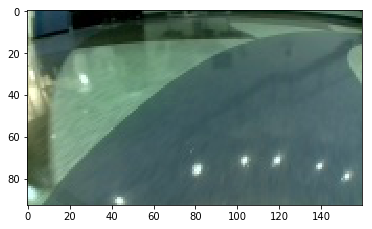

In [18]:
imshow(train_X[1])